# Principal Component Analysis with Cancer Data

In [194]:
#Import all the necessary modules
#Import all the necessary modules
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import r2_score

from scipy import stats

# Q1. Load the Data file into Python DataFrame and view top 10 rows

In [151]:
df = pd.read_csv("breast-cancer-wisconsin-data.csv")
df.head()

,ID,ClumpThickness,Cell Size,Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Normal Nucleoli,Bland Chromatin,Mitoses,Class
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2


In [0]:
  # Id columns is to identify rows hence can be skipped in analysis
  # All columns have numerical values
  # Class would be the target variable. Should be removed when PCA is done

# Q2 Print the datatypes of each column and the shape of the dataset. Perform descriptive analysis 

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 699 entries, 0 to 698
Data columns (total 11 columns):
ID                             699 non-null int64
ClumpThickness                 699 non-null int64
Cell Size                      699 non-null int64
Cell Shape                     699 non-null int64
Marginal Adhesion              699 non-null int64
Single Epithelial Cell Size    699 non-null int64
Bare Nuclei                    699 non-null object
Normal Nucleoli                699 non-null int64
Bland Chromatin                699 non-null int64
Mitoses                        699 non-null int64
Class                          699 non-null int64
dtypes: int64(10), object(1)
memory usage: 60.1+ KB


In [8]:
print("Shape of data: ", df.shape)

Shape of data:  (699, 11)


In [12]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,699,NaN,NaN,NaN,1.0717e+06,617096,61634,870688,1.17171e+06,1.2383e+06,1.34544e+07
ClumpThickness,699,NaN,NaN,NaN,4.41774,2.81574,1,2,4,6,10
Cell Size,699,NaN,NaN,NaN,3.13448,3.05146,1,1,1,5,10
Cell Shape,699,NaN,NaN,NaN,3.20744,2.97191,1,1,1,5,10
Marginal Adhesion,699,NaN,NaN,NaN,2.80687,2.85538,1,1,1,4,10
Single Epithelial Cell Size,699,NaN,NaN,NaN,3.21602,2.2143,1,2,2,4,10
Bare Nuclei,699,11,1,402,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Normal Nucleoli,699,NaN,NaN,NaN,3.43777,2.43836,1,2,3,5,10
Bland Chromatin,699,NaN,NaN,NaN,2.86695,3.05363,1,1,1,4,10
Mitoses,699,NaN,NaN,NaN,1.58941,1.71508,1,1,1,1,10


### COMMENT:
There are missing values in column 'Bare Nuclei'

# Q3 Check for missing value check, incorrect data, duplicate data and perform imputation with mean, median, mode as necessary.


In [ ]:
# We could see "?" values in column, this should be removed from data set

# Check for missing value in any other column

As per the describe(include="all"), only "Bare Nuclei" is of object type. All other columns are of int type.
Checking the csv file, it is observed, that a few columns in "Bare Nuclei" are with value "?".

In [46]:
# No missing values found. So let us try to remove ? from bare nuclei column

# Get count of rows having ?
print("Number of data points with '?' in column 'Bare Nuclei': ", df[df["Bare Nuclei"].str.isnumeric()==False].shape[0])

Number of data points with '?' in column 'Bare Nuclei':  16


In [0]:
# 16 values are corrupted. We can either delete them as it forms roughly 2% of data.
# Here we would like to impute it with suitable values

In [61]:
# Use modelling (instead of mean/median/mode) to predict value in missing "Bare Nuclei"

def predMissing_bareNuclei(df_in):
    
    # Speerate the rows containing non-numeric value in hp
    
    df_in["isNumeric"] = df_in["Bare Nuclei"].str.isnumeric()
    # Seperate rows with numeric value in "hp" from rows without numeric value in "hp"
    missing_numeric_df = df_in[df_in.isNumeric == False]
    valid_numeric_df = df_in[df_in.isNumeric == True]
    # Convert hp column to numeric in the df with numeric values in the column
    valid_numeric_df["Bare Nuclei"] = pd.to_numeric(valid_numeric_df["Bare Nuclei"])
    # Drop column
    missing_numeric_df.drop("isNumeric", axis=1, inplace=True)
    valid_numeric_df.drop("isNumeric", axis=1, inplace=True)
    
    # Create test and train data set for model building
    
    X = valid_numeric_df.drop("Bare Nuclei", axis=1)
    Y = valid_numeric_df["Bare Nuclei"]
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=0)
    
    # Build the model to predict hp
    
    regr = linear_model.LinearRegression()
    regr.fit(x_train, y_train)
    y_pred = regr.predict(x_test)
    # r-squared
    r2 = r2_score(y_test, y_pred)
    # Adjusted r-squared
    ad_r2 = 1 - (1 - r2) * (len(y_train) - 1) / (len(y_train) - X.shape[1] - 1)
    print("R squared for the linear regression: ", r2)
    print("Adjusted R squared: ", ad_r2)
    
    # Predict the hp values, in the missing hp rows
    
    prediction = regr.predict(missing_numeric_df.drop("Bare Nuclei", axis=1))
    missing_numeric_df["Bare Nuclei"] = pd.to_numeric(prediction)
    # Change the column from float to int
    missing_numeric_df["Bare Nuclei"] = missing_numeric_df["Bare Nuclei"].apply(np.int8)
    
    #
    # Combine the predicted rows with other rows
    # Concat the rows (axis = 0)
    df_out = pd.concat([missing_numeric_df, valid_numeric_df], axis=0)
    df_out.head()
    
    return df_out

In [152]:
df = predMissing_bareNuclei(df)
df.info()

R squared for the linear regression:  0.6691022921625963
Adjusted R squared:  0.6620166881403822
<class 'pandas.core.frame.DataFrame'>
Int64Index: 699 entries, 23 to 698
Data columns (total 11 columns):
ID                             699 non-null int64
ClumpThickness                 699 non-null int64
Cell Size                      699 non-null int64
Cell Shape                     699 non-null int64
Marginal Adhesion              699 non-null int64
Single Epithelial Cell Size    699 non-null int64
Bare Nuclei                    699 non-null int64
Normal Nucleoli                699 non-null int64
Bland Chromatin                699 non-null int64
Mitoses                        699 non-null int64
Class                          699 non-null int64
dtypes: int64(11)
memory usage: 65.5 KB


# Q4. Perform bi variate analysis including correlation, pairplots and state the inferences. 


In [49]:
# Check for correlation of variable
corr_df = df.corr()
corr_df

,ID,ClumpThickness,Cell Size,Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Normal Nucleoli,Bland Chromatin,Mitoses,Class
ID,1.000000,-0.055308,-0.041603,-0.041576,-0.064878,-0.045528,-0.093119,-0.060051,-0.052072,-0.034901,-0.080226
ClumpThickness,-0.055308,1.000000,0.644913,0.654589,0.486356,0.521816,0.594978,0.558428,0.535835,0.350034,0.716001
Cell Size,-0.041603,0.644913,1.000000,0.906882,0.705582,0.751799,0.689847,0.755721,0.722865,0.458693,0.817904
Cell Shape,-0.041576,0.654589,0.906882,1.000000,0.683079,0.719668,0.711957,0.735948,0.719446,0.438911,0.818934
Marginal Adhesion,-0.064878,0.486356,0.705582,0.683079,1.000000,0.599599,0.665321,0.666715,0.603352,0.417633,0.696800
Single Epithelial Cell Size,-0.045528,0.521816,0.751799,0.719668,0.599599,1.000000,0.582023,0.616102,0.628881,0.479101,0.682785
Bare Nuclei,-0.093119,0.594978,0.689847,0.711957,0.665321,0.582023,1.000000,0.680080,0.578979,0.340899,0.824125
Normal Nucleoli,-0.060051,0.558428,0.755721,0.735948,0.666715,0.616102,0.680080,1.000000,0.665878,0.344169,0.756616
Bland Chromatin,-0.052072,0.535835,0.722865,0.719446,0.603352,0.628881,0.578979,0.665878,1.000000,0.428336,0.712244
Mitoses,-0.034901,0.350034,0.458693,0.438911,0.417633,0.479101,0.340899,0.344169,0.428336,1.000000,0.423170


In [54]:
# Define a function to find correlations higher than a given threshold
def correlationThresholdCutter(corr_data, threshold, targetLabel):
    #corr_threshold = 0.70;
    count = 0;
    if targetLabel == "":
        targetLabel == ""

    corr_threshold = threshold**2   # Square to get positive value for negative values as well
    count = 0

    for i in range(0, len(corr_data)):
        #for j in range(0, len(x_cor)):

        # X and Y axis columns are same. Limiting j to (i + 1) will only compare once between 2 columns.
        # Without this same columns will be compared twice.
        for j in range(0, i + 1):
            entry = corr_data.iloc[i, j]
            entry_squared = entry**2
            if(entry_squared >= corr_threshold):
                x_axis_col_lab = corr_data.index.values[i]
                y_axis_col_lab = corr_data.index.values[j]
                if x_axis_col_lab != y_axis_col_lab:
                    count = count + 1
                    if(x_axis_col_lab == targetLabel):
                        print("***", x_axis_col_lab, "*** corr with ", y_axis_col_lab, " is: ", entry)
                    elif y_axis_col_lab == targetLabel:
                        print(x_axis_col_lab, " corr with ***", y_axis_col_lab, "*** is: ", entry)
                    else:
                        print(x_axis_col_lab, " corr with ", y_axis_col_lab, " is: ", entry)
                    
    print("***")
    print("Number of relations with correlation higher than ", threshold, ": ", count)
    return


# Call the function

correlationThresholdCutter(corr_df, 0.70, "Class")

Cell Shape  corr with  Cell Size  is:  0.9068819130526031
Marginal Adhesion  corr with  Cell Size  is:  0.7055818115571197
Single Epithelial Cell Size  corr with  Cell Size  is:  0.7517991298771355
Single Epithelial Cell Size  corr with  Cell Shape  is:  0.7196684371703584
Bare Nuclei  corr with  Cell Shape  is:  0.7119566628698394
Normal Nucleoli  corr with  Cell Size  is:  0.7557209811005801
Normal Nucleoli  corr with  Cell Shape  is:  0.7359484540233039
Bland Chromatin  corr with  Cell Size  is:  0.7228648219063656
Bland Chromatin  corr with  Cell Shape  is:  0.7194463169532814
*** Class *** corr with  ClumpThickness  is:  0.7160013621134115
*** Class *** corr with  Cell Size  is:  0.8179037353075624
*** Class *** corr with  Cell Shape  is:  0.8189337394205303
*** Class *** corr with  Bare Nuclei  is:  0.8241245590179372
*** Class *** corr with  Normal Nucleoli  is:  0.756616146378908
*** Class *** corr with  Bland Chromatin  is:  0.7122436220251168
***
Number of relations with corr

In [0]:
# Cell size shows high significance with cell shape,marginal adhesion, single epithelial cell size,bare nuclei, normal nucleoli 
# and bland chromatin
# Target variable shows high correlation with most of these variables

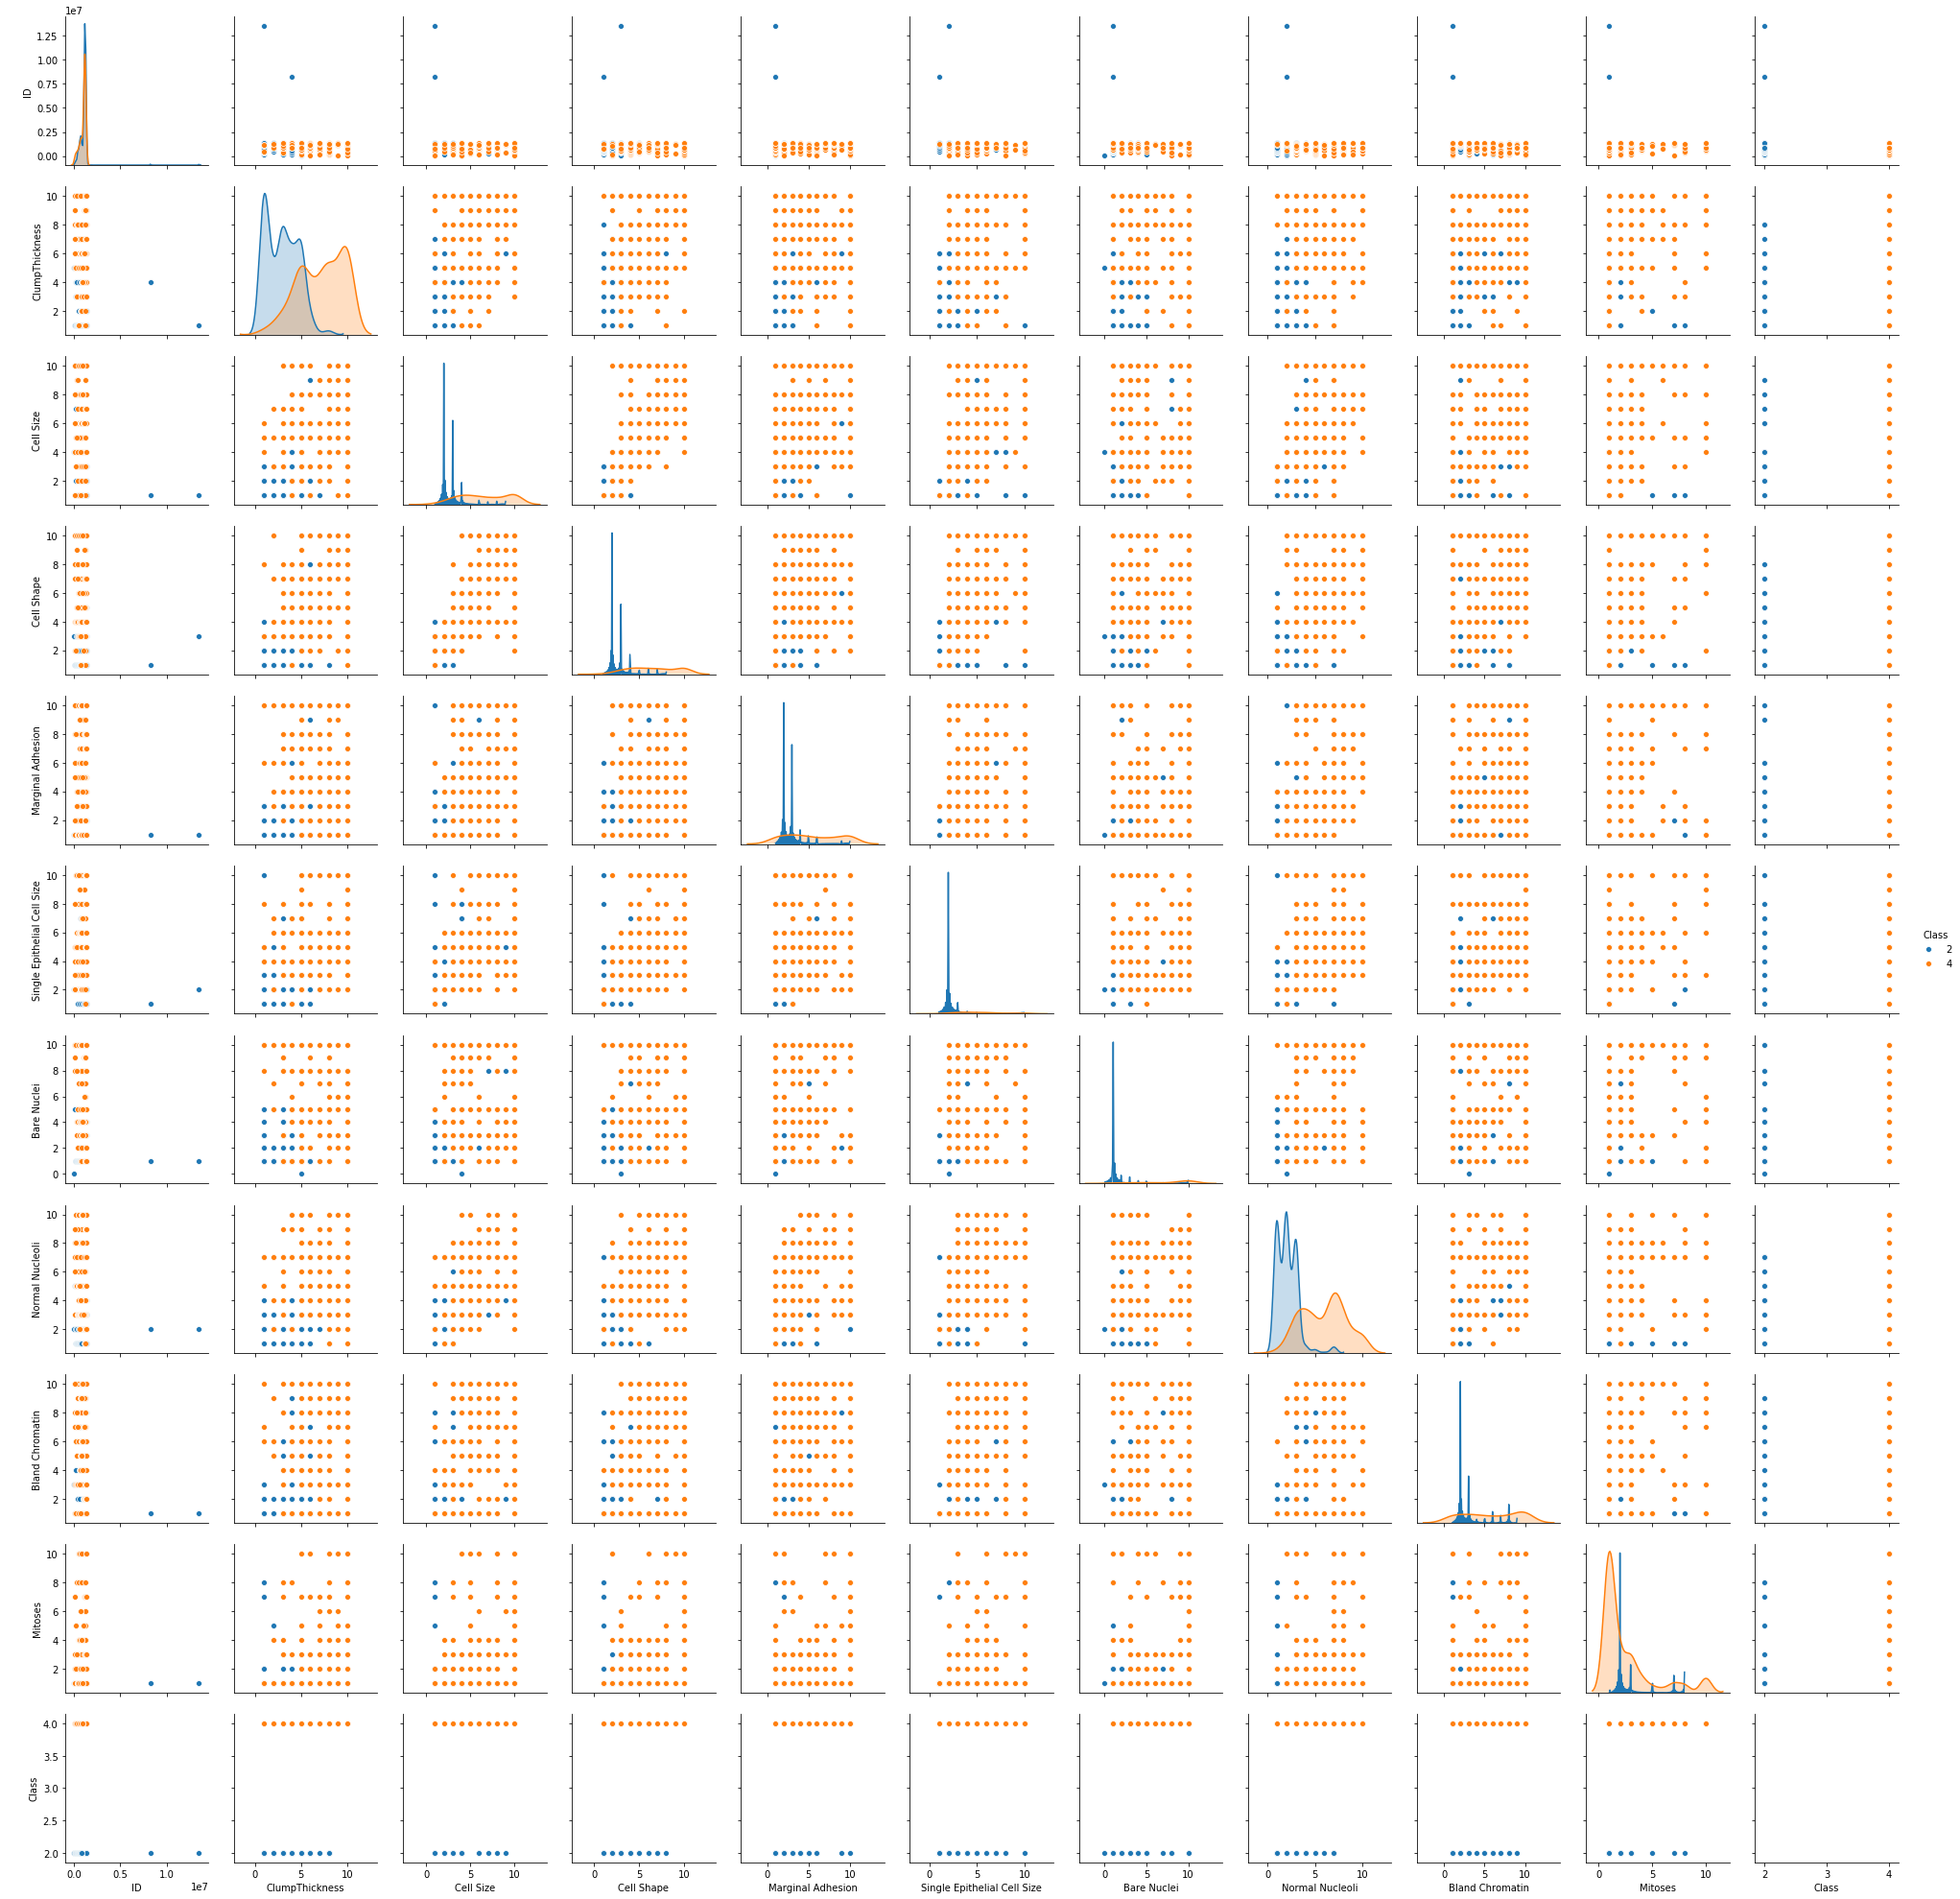

In [55]:
#Let us check for pair plots
sns.pairplot(df, diag_kind='kde' , hue = 'Class')

Following can be inferenced from the pair plots:
- Following features seem to be evenly distributed for different Class
    - ID
    - Mitoses
- At higher values of ClumpThickness the value 4 is more prominent for the Class
- Similar distribution for following features, around the Class values. They are likely to be highly correlated.
    - Cell Size
    - Cell Shape
    - Marginal Adhession
    - Bland Chromatin
- There seems a class imbalance in the data for
    - Single Epithelial Cell Size
    - Bare Nuclei
- At higher value of Normal Nucleoli, Class value of 4 is more prominant

In [0]:
# Relationship between variables shows come correlation. 
# Distribution of variables shows most of the values are concentrated on lower side, though range remains same for all that is 
# Between 1 to 10

# Q5 Remove any unwanted columns or outliers, standardize variables in pre-processing step

In [0]:
# We could see most of the outliers are now removed.

In [153]:
# Remove ID and Mitosis
df.drop(["ID", "Mitoses"], axis = 1, inplace=True)

In [80]:
df.nunique()

ClumpThickness                 10
Cell Size                      10
Cell Shape                     10
Marginal Adhesion              10
Single Epithelial Cell Size    10
Bare Nuclei                    11
Normal Nucleoli                10
Bland Chromatin                10
Class                           2
dtype: int64

In [82]:
df["Bare Nuclei"].describe()

count    699.000000
mean       3.502146
std        3.621954
min        0.000000
25%        1.000000
50%        1.000000
75%        5.500000
max       10.000000
Name: Bare Nuclei, dtype: float64

In [98]:
df[df["Bare Nuclei"] == 0]

,ClumpThickness,Cell Size,Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Normal Nucleoli,Bland Chromatin,Class,outlier
297,5,4,3,1,2,0,2,3,2,False


0 is an outlier in "Bare Nuclei"

In [111]:
# Define function to predict in a column based on lowerbound and upperbound values provided
def predReplacementForOutlier(df_in, columnName, lowerbound, upperbound):
    
    # Speerate the rows containing non-numeric value in hp
    
    df_in["outlier"] = (df_in[columnName] <= lowerbound) | (df_in[columnName] > upperbound)
    #
    outlier_df = df_in[df_in.outlier == True]
    valid_df = df_in[df_in.outlier == False]
    # Drop column
    outlier_df.drop("outlier", axis=1, inplace=True)
    valid_df.drop("outlier", axis=1, inplace=True)
    
    print(outlier_df.shape)
    
    # Create test and train data set for model building
    
    X = valid_df.drop(columnName, axis=1)
    Y = valid_df[columnName]
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.30, random_state=0)
    
    # Build the model to predict hp
    
    regr = linear_model.LinearRegression()
    regr.fit(x_train, y_train)
    y_pred = regr.predict(x_test)
    # r-squared
    r2 = r2_score(y_test, y_pred)
    # Adjusted r-squared
    ad_r2 = 1 - (1 - r2) * (len(y_train) - 1) / (len(y_train) - X.shape[1] - 1)
    print("R squared for the linear regression: ", r2)
    print("Adjusted R squared: ", ad_r2)
    
    # Predict
    
    prediction = regr.predict(outlier_df.drop(columnName, axis=1))
    outlier_df[columnName] = pd.to_numeric(prediction)
    # Change the column from float to int
    outlier_df[columnName] = outlier_df[columnName].apply(np.int8)
    
    #
    # Combine the predicted rows with other rows
    # Concat the rows (axis = 0)
    df_out = pd.concat([outlier_df, valid_df], axis=0)
    df_out.head()
    
    return df_out

In [154]:
# One of the value in "Bare Nuclei" is 0. Replace it using the prediction method.
df = predReplacementForOutlier(df, "Bare Nuclei", 0, 10)

(1, 9)
R squared for the linear regression:  0.6906172466163949
Adjusted R squared:  0.6854501025097794


# Q6 Create a covariance matrix for identifying Principal components

In [155]:
X = df.drop("Class", axis=1)
Y = df.Class

In [156]:
# PCA
# Step 1 - Create covariance matrix
train_cov_matrix = np.cov(X.T)
train_cov_matrix

array([[ 7.92839546,  5.541164  ,  5.47769019,  3.91030781,  3.25346893,
         6.06870437,  3.83405684,  4.60723465],
       [ 5.541164  ,  9.3114027 ,  8.22421306,  6.14778583,  5.07979061,
         7.62559284,  5.62299396,  6.73568258],
       [ 5.47769019,  8.22421306,  8.8322655 ,  5.79656775,  4.73592648,
         7.66329714,  5.33312837,  6.52907141],
       [ 3.91030781,  6.14778583,  5.79656775,  8.1531906 ,  3.7910646 ,
         6.8781989 ,  4.64197523,  5.26080032],
       [ 3.25346893,  5.07979061,  4.73592648,  3.7910646 ,  4.90312399,
         4.66613172,  3.32649999,  4.25227812],
       [ 6.06870437,  7.62559284,  7.66329714,  6.8781989 ,  4.66613172,
        13.10994421,  6.00416272,  6.40377166],
       [ 3.83405684,  5.62299396,  5.33312837,  4.64197523,  3.32649999,
         6.00416272,  5.94562023,  4.95804075],
       [ 4.60723465,  6.73568258,  6.52907141,  5.26080032,  4.25227812,
         6.40377166,  4.95804075,  9.32467996]])

# Q7 Identify eigen values and eigen vector

In [ ]:
# Step 2- Get eigen values and eigen vector

In [157]:
eigenvalues, eigenvectors = np.linalg.eig(train_cov_matrix)
print('Eigen Vectors \n%s', eigenvectors)
print('\n Eigen Values \n%s', eigenvalues)

Eigen Vectors 
%s [[-0.30081253 -0.09193043 -0.84354843  0.05828809 -0.42392789  0.00345743
   0.02670734  0.07516029]
 [-0.40706315  0.23918862 -0.02955434  0.31972926  0.30133983  0.72596471
  -0.05474741 -0.23056541]
 [-0.39521945  0.17465733 -0.07638902  0.23345167  0.34167974 -0.66786922
  -0.04066448 -0.43418142]
 [-0.33307525 -0.08644206  0.49245791  0.38439377 -0.67997893 -0.04408692
   0.13640584 -0.0916173 ]
 [-0.25038456  0.18832962  0.03839662  0.18950391  0.24649143 -0.11752932
   0.51335984  0.7254957 ]
 [-0.44517221 -0.77854461  0.10593651 -0.3317238   0.2316505   0.06147901
   0.12703029 -0.02912824]
 [-0.29510883  0.02951704  0.11663249 -0.00892817 -0.00177348 -0.08255469
  -0.82564087  0.45809977]
 [-0.35876724  0.50387417  0.11358927 -0.73897586 -0.18957832  0.02371188
   0.12112565 -0.0850613 ]]

 Eigen Values 
%s [47.89862549  5.02738502  4.27503221  3.09192312  2.71524122  0.80234335
  1.97073866  1.72733356]


# Q8 Find variance and cumulative variance by each eigen vector

In [158]:
# Step 3 (continued): Sort eigenvalues in descending order

# Make a set of (eigenvalue, eigenvector) pairs
train_eig_pairs = [(eigenvalues[index], eigenvectors[:,index]) for index in range(len(eigenvalues))]

# Sort the (eigenvalue, eigenvector) pairs from highest to lowest with respect to eigenvalue
train_eig_pairs.sort()

train_eig_pairs.reverse()
print(train_eig_pairs)

# Extract the descending ordered eigenvalues and eigenvectors
train_eigvalues_sorted = [train_eig_pairs[index][0] for index in range(len(eigenvalues))]
train_eigvectors_sorted = [train_eig_pairs[index][1] for index in range(len(eigenvalues))]

# Let's confirm our sorting worked, print out eigenvalues
print()
print('Eigenvalues in descending order: \n%s' %train_eigvalues_sorted)

[(47.89862548809231, array([-0.30081253, -0.40706315, -0.39521945, -0.33307525, -0.25038456,
       -0.44517221, -0.29510883, -0.35876724])), (5.0273850209939095, array([-0.09193043,  0.23918862,  0.17465733, -0.08644206,  0.18832962,
       -0.77854461,  0.02951704,  0.50387417])), (4.275032211416101, array([-0.84354843, -0.02955434, -0.07638902,  0.49245791,  0.03839662,
        0.10593651,  0.11663249,  0.11358927])), (3.0919231220731116, array([ 0.05828809,  0.31972926,  0.23345167,  0.38439377,  0.18950391,
       -0.3317238 , -0.00892817, -0.73897586])), (2.7152412154439647, array([-0.42392789,  0.30133983,  0.34167974, -0.67997893,  0.24649143,
        0.2316505 , -0.00177348, -0.18957832])), (1.9707386630523769, array([ 0.02670734, -0.05474741, -0.04066448,  0.13640584,  0.51335984,
        0.12703029, -0.82564087,  0.12112565])), (1.7273335612054548, array([ 0.07516029, -0.23056541, -0.43418142, -0.0916173 ,  0.7254957 ,
       -0.02912824,  0.45809977, -0.0850613 ])), (0.8023

In [159]:
tot = sum(eigenvalues)
var_explained = [(i / tot) for i in sorted(train_eigvalues_sorted, reverse=True)]  # an array of variance explained by each 
# eigen vector...
cum_var_exp = np.cumsum(var_explained)  # an array of cumulative variance. There will be 8 entries with 8 th entry 
# cumulative reaching almost 100%

cum_var_exp

array([0.70951863, 0.7839889 , 0.84731462, 0.89311503, 0.93333569,
       0.96252809, 0.98811495, 1.        ])

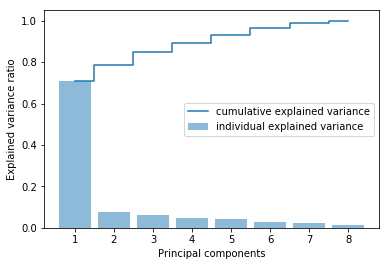

In [160]:
upperRange = len(cum_var_exp)

plt.bar(range(1,1+upperRange), var_explained, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,1+upperRange),cum_var_exp, where= 'mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc = 'best')
plt.show()

First 3 vectors seem to have significant impact

# Q9 Use PCA command from sklearn and find Principal Components. Transform data to components formed

In [161]:
# Since only first 3 vectors seem to have significant eigen values, therefore keep only them
P_reduce = np.array(train_eigvectors_sorted[0:3])

X_3d = np.dot(X,P_reduce.T)   # projecting original data into principal component dimensions

Proj_data_df = pd.DataFrame(X_3d)  # converting array to dataframe for pairplot

Proj_data_df.head()

,0,1,2
0,-7.263510,2.103404,-3.315906
1,-13.102963,-2.346756,-4.780548
2,-16.944800,4.964016,0.902565
3,-3.080712,0.208167,0.034154
4,-4.121535,0.745811,-0.080228


# Q10 Find correlation between components and features

In [150]:
Proj_data_df.corr()

,0,1,2
0,1.000000e+00,-1.085432e-15,-3.896306e-16
1,-1.085432e-15,1.000000e+00,9.776602e-16
2,-3.896306e-16,9.776602e-16,1.000000e+00


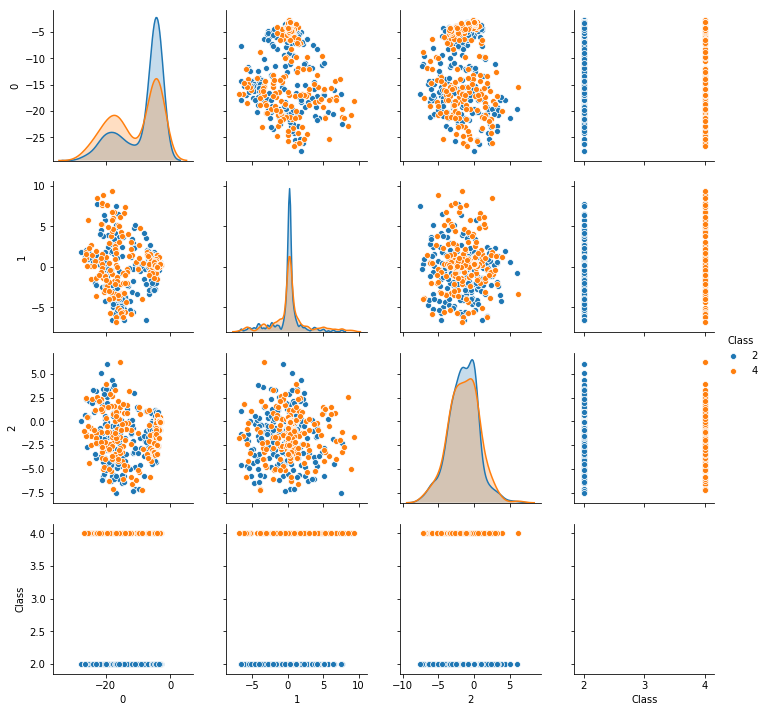

In [164]:
#Let us check it visually
Proj_data_class_df = Proj_data_df.join(Y)

sns.pairplot(Proj_data_class_df, diag_kind='kde', hue="Class")

# Content Based Recommendation System - Optional ( Q11 - Q18 will not be graded)

# Q11 Read the Dataset `movies_metadata.csv`

# Q12 Create a new column with name 'description' combining `'overview' and 'tagline'` columns in the given dataset

# Q13  Lets drop the null values in `description` column

# Q14 Keep the first occurance and drop duplicates of each title in column `title`

# Q15   As we might have dropped a few rows with duplicate `title` in above step, just reset the index [make sure you are not adding any new column to the dataframe while doing reset index]

# Q16  Create cosine similarity matrix

# Q17  Write a function with name `recommend` which takes `title` as argument and returns a list of 10 recommended title names in the output based on the above cosine similarities

Hint:

titles = df['title'] <br>
indices = pd.Series(df.index, index=df['title']) <br>

def recommend(title): <br>
    idx = indices[title] <br>
    sim_scores = list(enumerate(cosine_similarities[idx])) <br>
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True) <br>
    sim_scores = sim_scores[1:31] <br>
    movie_indices = [i[0] for i in sim_scores] <br>
    return titles.iloc[movie_indices] <br>

# Q18 Give the recommendations from above functions for movies `The Godfather` and `The Dark Knight Rises`

# Popularity Based Recommendation System

### About Dataset

Anonymous Ratings on jokes.

1. Ratings are real values ranging from -10.00 to +10.00 (the value "99" corresponds to "null" = "not rated").

2. One row per user

3. The first column gives the number of jokes rated by that user. The next 100 columns give the ratings for jokes 01 - 100.

# Q19 Read the dataset(jokes.csv)

Take care about the header in read_csv() as there are no column names given in the dataset. 

In [165]:
df_j = pd.read_csv("jokes.csv")
df_j.shape

(24983, 101)

# Q20 Consider `ratings` named dataframe with only first 200 rows and all columns from 1(first column is 0) of dataset

In [170]:
df_j_2 = df_j.iloc[0:200, 1:101]
df_j_2.shape

(200, 100)

In [171]:
df_j_2.head()

,Joke1,Joke2,Joke3,Joke4,Joke5,Joke6,Joke7,Joke8,Joke9,Joke10,...,Joke91,Joke92,Joke93,Joke94,Joke95,Joke96,Joke97,Joke98,Joke99,Joke100
0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,...,2.82,99.00,99.00,99.00,99.00,99.00,-5.63,99.00,99.00,99.00
1,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,...,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,99.00,99.00,99.00,99.00,9.03,9.27,9.03,9.27,99.00,99.00,...,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00
3,99.00,8.35,99.00,99.00,1.80,8.16,-2.82,6.21,99.00,1.84,...,99.00,99.00,99.00,0.53,99.00,99.00,99.00,99.00,99.00,99.00
4,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,...,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60


# Q21 Change the column indices from 0 to 99

In [173]:
df_j_2.columns = range(0,100)
df_j_2.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-7.82,8.79,-9.66,-8.16,-7.52,-8.50,-9.85,4.17,-8.98,-4.76,...,2.82,99.00,99.00,99.00,99.00,99.00,-5.63,99.00,99.00,99.00
1,4.08,-0.29,6.36,4.37,-2.38,-9.66,-0.73,-5.34,8.88,9.22,...,2.82,-4.95,-0.29,7.86,-0.19,-2.14,3.06,0.34,-4.32,1.07
2,99.00,99.00,99.00,99.00,9.03,9.27,9.03,9.27,99.00,99.00,...,99.00,99.00,99.00,9.08,99.00,99.00,99.00,99.00,99.00,99.00
3,99.00,8.35,99.00,99.00,1.80,8.16,-2.82,6.21,99.00,1.84,...,99.00,99.00,99.00,0.53,99.00,99.00,99.00,99.00,99.00,99.00
4,8.50,4.61,-4.17,-5.39,1.36,1.60,7.04,4.61,-0.44,5.73,...,5.19,5.58,4.27,5.19,5.73,1.55,3.11,6.55,1.80,1.60


# Q22 In the dataset, the null ratings are given as 99.00, so replace all 99.00s with 0
Hint: You can use `ratings.replace(<the given value>, <new value you wanted to change with>)`

In [193]:
# Replace 99 with 0
df_in = df_j_2

columnsList = df_in.columns
print(len(columnsList))

for i in range(0, len(columnsList)):    # Enter column
    #print(i)
    for j in range(0, len(df_in)):      # Enter row
        #print(j)
        entry = df_in.iloc[j,i]
        if entry == 99:
            df_in.iloc[j,i] = 0
            #print("99 at: ", j, ", ", i)

100


# Q23 Normalize the ratings using StandardScaler and save them in `ratings_diff` variable

In [201]:
#from scipy import stats
ratings_z = stats.zscore(df_in)
ratings_diff = pd.DataFrame(ratings_z)
ratings_diff.shape

(200, 100)

### Popularity based recommendation system

# Q24  Find the mean for each column  in `ratings_diff` i.e, for each joke
Consider all the mean ratings and find the jokes with highest mean value and display the top 10 joke IDs.

In [209]:
#ratings_diff.describe()
mean_ratings = ratings_diff.mean()
type(mean_ratings)

pandas.core.series.Series

In [207]:
mean_ratings.sort_values(ascending=False).head(10)

98    1.840889e-16
81    1.243450e-16
97    1.198694e-16
20    1.065814e-16
94    1.054712e-16
92    8.770762e-17
47    7.771561e-17
73    7.743806e-17
99    7.549517e-17
49    7.494005e-17
dtype: float64

In [211]:
#df_in.head(200)